<a href="https://colab.research.google.com/github/BEAR821/Searching-Perceptually-equivalent-Space/blob/main/main_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Hyperparameters

In [302]:
model_name = 'efficientnet_b7' # the name of pre-trained model from torchvision.models

Fix_seed = False # boolean to fix the random seed or not

seed =100 # Set random seed if Fix_seed==False, it gonna ignored

label_size = 50 # N of the report : the number of sampling labels ( for statictical safty )

sample_size = 150 # B of the report : the number of sampling images per label ( for statictical safty )

import torch

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

# pre-trained Model Mount

In [303]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [304]:
import torchvision.models as models
import torchvision
import torch

In [305]:
def getPretrainedModel(model_name):

  model_dict = {'RESNET' : 'resnet', 'VGG' : 'vgg', "EFFICIENTNET" : 'efficientnet', 'INCEPTION' : 'inception'}
  modelWeight_dict = {'RESNET' : 'ResNet@_Weights', 'VGG' : 'VGG@_Weights', 'EFFICIENTNET' : 'EfficientNet@_Weights', 'INCEPTION' : 'Inception@_Weights'}

  c = None
  for i, word in enumerate(model_name):
    if word.isdigit() or word=='_':
      c = i
      break
      
  modelkind = model_name[:c]
  modelversion = model_name[c:]

  if modelkind.upper() in model_dict.keys():
    name = model_dict[modelkind.upper()]

    wname1, wname2 = modelWeight_dict[modelkind.upper()].split('@')

    model = getattr(models, name+modelversion)
    weights = getattr(models, wname1+modelversion.upper()+wname2)
  else:
    raise print('Wrong Name')
  
  return model(weights = weights), name


In [ ]:
classifier, modelkind = getPretrainedModel(model_name)
classifier.to(device)

# Define & Summary of Model

In [309]:
class MyModel(torch.nn.Module):
    def __init__(self, classifier, modelkind):
        super(MyModel, self).__init__()
        self.f = []
        self.modelname = modelkind
        self.name = []
        self.idenlayer = nn.Identity()

        self.classifier = self.getModelLayers(classifier, modelkind)

        self.f, self.name = self.findF(self.classifier)

        

        for name, layer in self.classifier:
          for para in layer.parameters():
            para.requires_grad = False

    def getModelLayers(self, classifier, modelkind):
      op =[]
      op.append(('idenity', self.idenlayer))
      if modelkind == 'vgg':
        key = None
        for name, layer in classifier.named_modules():
          if key is None and 'features.0' in name:
            key = 1
          if key == 1:
            layer.to(device)
            op.append((name,layer))
          if 'classifier' in name and key == 1:
            break
      elif modelkind == 'resnet':
        s= 0
        for name, layer in classifier.named_modules():
          s=1
          if name == '':
            s=0
          for i in range(1, 5):
            for j in range(7):
              if ('layer'+str(i)+'.'+str(j) in name and 'layer'+str(i)+'.'+str(j) != name ) or 'layer'+str(i) == name:
                s=0

          if s==1:
            layer.to(device)
            op.append((name, layer))
      elif modelkind == 'efficientnet':
        s= 0
        for name, layer in classifier.named_modules():
          s= 0
          for i in range(0, 30):
            if name == 'features.'+str(i):
              s=1

          if s==1:
            layer.to(device)
            op.append((name, layer))
      return op
    
    def findF(self, classifier):
      multi = 1
      f = []
      layer_place = []

      x = torch.zeros(1, 3, 256, 256)
      x = x.to(device)
      H = x.size(-1)
      for i, (namel, layer) in enumerate(classifier):
        x = layer(x)
        if self.modelname =='resnet' and x.size(-1) == 1 and x.size(-2) == 1:
            x  = nn.Flatten()(x)
        if self.modelname =='vgg' and x.size(-1) == 7 and x.size(-2) == 7:
            x  = nn.Flatten()(x)
        h = x.size(-1)
        if H != h:
          if H//h == 0:
            break
          f.append(multi)
          multi *= H//h
          if i ==0 :
            raise
          layer_place.append(i-1)
          H = h
      
      return f, layer_place

    def forward(self, x):
        out = {}
        y = {}
        i = 0
        for i, (_, layer) in enumerate(self.classifier):
          x = layer(x)
          if len(x.size())>=3:
            o = torch.sum((x[0, :, :, :]-x[1, :, :, :])**2)/(torch.norm(x[0])**2 + torch.norm(x[1])**2)
            o = o.to('cpu')
            o = o.numpy()
            y[i] = o
            if i in self.name:
              out[i] = o
            else:
              out[i] = 0
          if self.modelname =='resnet' and x.size(-1) == 1 and x.size(-2) == 1:
            x  = nn.Flatten()(x)
          if self.modelname =='vgg' and x.size(-1) == 7 and x.size(-2) == 7:
            x  = nn.Flatten()(x)
          i+=1
        return out, y


In [310]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import os
import time
import torch.nn.functional as F
import numpy as np
import random


# fix randomness with seed
if Fix_seed:
  print('random seed is fixed to : ',seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)

print('label size : ', label_size)

print('sample size : ', sample_size)

print('kind of model : ', modelkind)



model = MyModel(classifier, modelkind)
model.to(device)

f = model.f
name = model.name

print('Compressing series : ', f)
print('The number of layer to evaluate : ', name)

label size :  50
sample size :  150
kind of model :  efficientnet
Compressing series :  [1, 2, 4, 8, 16]
The number of layer to evaluate :  [0, 2, 3, 4, 6]


# Set DataSet & Inference

In [311]:
# root directory of train dataset
data_root = '/content/drive/MyDrive/KAIST/CS492(I)/data/tiny-imagenet-200/tiny-imagenet-200/train'

In [312]:
# checking dataset

dirlist = os.listdir(data_root)
print('The number of labels : ', len(dirlist))
random.shuffle(dirlist)

dirlsit = dirlist[:label_size]

print('labels for inference', dirlist)

import shutil
cnt = 0

for dir in dirlist:
  traindir = data_root+'/'+dir+'/images'
  if not os.path.isdir(traindir):
    shutil.rmtree(data_root+'/'+dir)
    cnt+=1
  else: 
    if not os.listdir(traindir):
      os.rmdir(traindir)
      cnt+=1

print(cnt)

if cnt != 0:
  raise print('Abnormal data was asigned. Please run this cell again')

The number of labels :  109
labels for inference ['n03404251', 'n02231487', 'n02233338', 'n02125311', 'n02769748', 'n01768244', 'n03255030', 'n02226429', 'n02948072', 'n03400231', 'n01770393', 'n02002724', 'n02480495', 'n02802426', 'n02132136', 'n02950826', 'n03085013', 'n02268443', 'n03388043', 'n02788148', 'n02815834', 'n02364673', 'n02415577', 'n02814533', 'n02963159', 'n03126707', 'n02669723', 'n02481823', 'n02793495', 'n02395406', 'n02666196', 'n02892201', 'n02056570', 'n01950731', 'n02437312', 'n02106662', 'n02190166', 'n03179701', 'n03424325', 'n01944390', 'n03447447', 'n01742172', 'n03042490', 'n02165456', 'n02808440', 'n02099601', 'n02321529', 'n01855672', 'n02074367', 'n02113799', 'n03160309', 'n02814860', 'n02085620', 'n03014705', 'n03100240', 'n02236044', 'n02699494', 'n01641577', 'n02403003', 'n02509815', 'n02058221', 'n01882714', 'n03201208', 'n01698640', 'n02837789', 'n02094433', 'n01910747', 'n01784675', 'n01629819', 'n02999410', 'n03026506', 'n02841315', 'n02795169', '

In [313]:
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                os.listdir(self.root_dir)[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
o =[]
for dir in dirlist:
  traindir = data_root+'/'+dir
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
  train_dataset = datasets.ImageFolder(
      traindir,
      transforms.Compose([
          transforms.Resize(256),
          transforms.RandomResizedCrop(256),
          transforms.ToTensor(),
          normalize,
      ]))

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=2, shuffle=True, pin_memory=True, drop_last=True)

  u = []
  y = []

  for i, (images, _) in enumerate(train_loader):
    if i == sample_size:
      break
    images = images.to(device, non_blocking=True)

    model.eval()

    p, y_pred = model(images)
    
    u.append(p)
    y.append(y_pred)
  
  m_u = {}
  m_y = {}
  for i in u[0].keys():
    m_u[i] = 0
    for item in u:
      m_u[i] += item[i]
    m_u[i] = m_u[i]/(sample_size)
  for i in y[0].keys():
    m_y[i] = 0
    for item in y:
      m_y[i] += item[i]
    m_y[i] = m_y[i]/(sample_size)
  
  o.append((m_u,m_y))
  print(m_u)
  print(m_y)
  

In [315]:
mean_u = None
mean_y = None

n = label_size
for u, y in o:
  if mean_u is None:
    mean_u = u
    continue
  if mean_y is None:
    mean_y = y
    continue
  for i in u.keys():
    mean_u[i] += u[i]
  for i in y.keys():
    mean_y[i] += y[i]

for i in u.keys():
  mean_u[i] = mean_u[i] /(n)
for i in y.keys():
  mean_y[i] = mean_y[i] /(n)


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
{0: 2.050063748410842, 1: 0.0, 2: 1.4023054484407103, 3: 1.2376912489692373, 4: 1.5986093567371373, 5: 0.0, 6: 1.622608066248894, 7: 0.0, 8: 0.0, 9: 0.0}
{0: 2.049801238401235, 1: 0.7258424721260869, 2: 1.4026706554214154, 3: 1.2377872024575873, 4: 1.5985821007569634, 5: 1.6592775250116987, 6: 1.6224766873995466, 7: 1.6831968064228686, 8: 2.0497146444400145, 9: 2.138370751436551}


In [316]:
print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

print(mean_u)
print(mean_y)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
{0: 2.050063748410842, 1: 0.0, 2: 1.4023054484407103, 3: 1.2376912489692373, 4: 1.5986093567371373, 5: 0.0, 6: 1.622608066248894, 7: 0.0, 8: 0.0, 9: 0.0}
{0: 2.049801238401235, 1: 0.7258424721260869, 2: 1.4026706554214154, 3: 1.2377872024575873, 4: 1.5985821007569634, 5: 1.6592775250116987, 6: 1.6224766873995466, 7: 1.6831968064228686, 8: 2.0497146444400145, 9: 2.138370751436551}


# Analysis Data & Save Data

In [317]:
# root directory of save the result
save_root = '/content/drive/MyDrive/KAIST/CS492(I)/result'

Load_result = False

if Load_result:
  load_model = 'efficientnet_b4'
else:
  load_model = model_name


In [318]:
import numpy as np

def FindInflecionPoint(RDlist):

  if len(RDlist) <=3:
    print('too small to find inflection point')
    return -1
  else:
    grad = []
    cnt = None
    for i, m in enumerate(RDlist):
      if m == 0:
        continue
      if cnt is None:
        cnt = i
        continue
      grad.append((m-RDlist[cnt])/(i-cnt))
      cnt = i

    for i, g in enumerate(grad):
      if i == 0:
        continue
      if g < grad[i-1]:
        return name[i]
    
    print('there is no grad decrease')
    return -1

def Findf(RDlist):
  RDlist = np.array(RDlist)
  local_min = np.min(RDlist[RDlist!=0])
  local_min = np.where(RDlist==local_min)[0].item()
  next_local_max = local_min
  key = 0

  for i, m in enumerate(RDlist):
    if i >= local_min and m >= RDlist[next_local_max] :
      next_local_max = i
      key = 1
  
  if key ==0:
    print('there is no max')
    print('Test Failed')
    return -1
  
  a =  FindInflecionPoint(RDlist[local_min:next_local_max+1])
  if a != -1:
    a_value = RDlist[a]
    RDlist = RDlist[RDlist!=0]
    p = np.where(RDlist==a_value)[0]
    return f[a]
  else:
    if local_min+1 >= next_local_max:
      max_value = RDlist[next_local_max]
      RDlist = RDlist[RDlist!=0]
      p = np.where(RDlist==max_value)[0].item()
      return f[p]
    else:
      min_value = RDlist[local_min]
      RDlist = RDlist[RDlist!=0]
      p = np.where(RDlist==min_value)[0].item()
      return f[p+1]




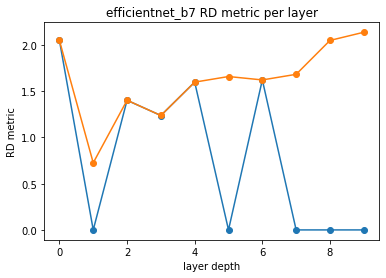

Optimul size f :  4 times compression


In [319]:
import matplotlib.pyplot as plt
import csv

if Load_result:
  with open(save_root+'/'+load_model+'/'+'resultl.csv', newline='') as csvfile:
    data = csv.reader(csvfile)
    i = 0

    for row in data:
      if i == 1:
        show_u = row
      if i == 2:
        show_y = row
      i+=1
    show_u = list(map(float, show_u))
    show_y = list(map(float, show_y))
else:
  show_u = list(mean_u.values())
  show_y = list(mean_y.values())

layer = [i for i in range(len(show_u))]

plt.plot(layer, show_u,  marker='o')
plt.plot(layer, show_y,  marker='o')
plt.title(load_model+' RD metric per layer')
plt.xlabel("layer depth")
plt.ylabel('RD metric')
plt.show()

result_f = Findf(show_u)

print('Optimul size f : ', result_f, 'times compression')

In [320]:
import csv
layer = [i for i in mean_u.keys()]
print(layer)

try:
  os.mkdir(save_root+'/'+model_name)
except:
  pass

if not Load_result:
  new_dict = [mean_u, mean_y]
  with open(save_root+'/'+model_name+'/'+'resultl.csv', 'w') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames = layer)
      writer.writeheader()
      writer.writerows(new_dict)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
